In [1]:
feat = [
    "IAT",
    "Variance",
    "Duration",
    "syn_count",
    "fin_count",
    "rst_count",
    "Tot_sum",
    "Protocol_Type",
    "Rate",
    "Min",
    "flow_duration",
    "Header_Length",
    "HTTP",
    "Number",
    "urg_count",
    "ack_count",
    "Covariance",
    "Tot_size",
    "Magnitue"
]


In [2]:
print(len(feat))

19


In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from scipy.stats import shapiro
import time
from river import drift


In [24]:
df  = pd.read_csv(r'F:\Projects\Cap_github\Capstone\Data\DoS_Recon.csv')

In [25]:
df.columns = df.columns.str.replace(' ', '_')

In [26]:
df['label'] = df['label'].apply(lambda x: 0 if 'DoS' in str(x) else 1)

In [27]:
# Filter the dataset to include only the columns in the 'feat' list
X = df[feat]  # Assuming 'feat' is a list of column names
y = df['label']
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.1, test_size=0.9, shuffle=True, random_state=0, stratify=y
)

# Splitting x_test and Y_test further into smaller test and remaining subsets
X_test, x_test_remainig, y_test, y_test_remaining = train_test_split(
    X_test, y_test, train_size=0.2, test_size=0.8, shuffle=True, random_state=0, stratify=y_test
)



In [28]:
# Import the online learning metrics and algorithms from the River library
from river import metrics
from river import stream
from river import tree,neighbors,naive_bayes,ensemble,linear_model,forest
from river.drift.binary import DDM, EDDM,HDDM_A,HDDM_W
import logging

In [29]:
#With drift of 80

def adaptive_learning(model, X_train, y_train, X_test, y_test):
    metric = metrics.Accuracy() # Use accuracy as the metric
    i = 0 # count the number of evaluated data points
    t = [] # record the number of evaluated data points
    m = [] # record the real-time accuracy
    yt = [] # record all the true labels of the test set
    yp = [] # record all the predicted labels of the test set
    
    eddm = drift.binary.EDDM()
    
    # Learn the training set
    for xi1, yi1 in zip(X_train.values, y_train): 
        xi = dict(zip(X_train.columns, xi1))   
        model.learn_one(xi, yi1) 

    # Predict the test set and perform drift detection
    for x_val, y_val in zip(X_test.values, y_test):
        x = dict(zip(X_test.columns, x_val))
        y_pred = model.predict_one(x)  # Predict the test sample
        model.learn_one(x, y_val) # Learn the test sample
        metric.update(y_val, y_pred) # Update the real-time accuracy
        
        # Drift detection part
        val = 0
        
        if y_val != y_pred:
           val = 1 
           eddm.update(y_val)
        if eddm.drift_detected:
            print(f"Change detected at index {i}, input value: {y_val}")
            
           
        if eddm.warning_detected:
           print(f"Warning detected at index {i}")
        # Print samples every 80 iterations
        if i % 80 == 0:
            print(f"Sample {i}: True label: {y_val}, Predicted label: {y_pred}") 

        # Performance evaluation
        t.append(i)
        m.append(metric.get() * 100)
        yt.append(y_val)
        yp.append(y_pred)
        i += 1

    print("Accuracy: " + str(round(accuracy_score(yt, yp), 4) * 100) + "%")
    print("Precision: " + str(round(precision_score(yt, yp), 4) * 100) + "%")
    print("Recall: " + str(round(recall_score(yt, yp), 4) * 100) + "%")
    print("F1-score: " + str(round(f1_score(yt, yp), 4) * 100) + "%")

    return t, m

In [30]:
# Define a figure function that shows the real-time accuracy changes
def acc_fig(t, m, name):
    plt.rcParams.update({'font.size': 15})
    plt.figure(1,figsize=(10,6)) 
    sns.set_style("darkgrid")
    plt.clf() 
    #if m:  # Check if m is not empty
    plt.plot(t, m, '-b', label='Avg Accuracy: %.2f%%' % (m[-1]))

    #plt.plot(t,m,'-b',label='Avg Accuracy: %.2f%%'%(m[-1]))

    plt.legend(loc='best')
    plt.title(name+' on CICIoT 2023 dataset', fontsize=15)
    plt.xlabel('Number of samples')
    plt.ylabel('Accuracy (%)')

    plt.draw()

Sample 0: True label: 1, Predicted label: 1
Sample 80: True label: 1, Predicted label: 1
Sample 160: True label: 0, Predicted label: 0
Sample 240: True label: 0, Predicted label: 0
Sample 320: True label: 1, Predicted label: 1
Sample 400: True label: 1, Predicted label: 1
Sample 480: True label: 1, Predicted label: 1
Sample 560: True label: 1, Predicted label: 1
Sample 640: True label: 0, Predicted label: 0
Sample 720: True label: 1, Predicted label: 1
Sample 800: True label: 0, Predicted label: 0
Sample 880: True label: 1, Predicted label: 1
Sample 960: True label: 1, Predicted label: 1
Sample 1040: True label: 1, Predicted label: 1
Sample 1120: True label: 0, Predicted label: 0
Sample 1200: True label: 0, Predicted label: 0
Sample 1280: True label: 0, Predicted label: 0
Sample 1360: True label: 0, Predicted label: 0
Sample 1440: True label: 1, Predicted label: 1
Sample 1520: True label: 0, Predicted label: 0
Sample 1600: True label: 0, Predicted label: 0
Sample 1680: True label: 0, P

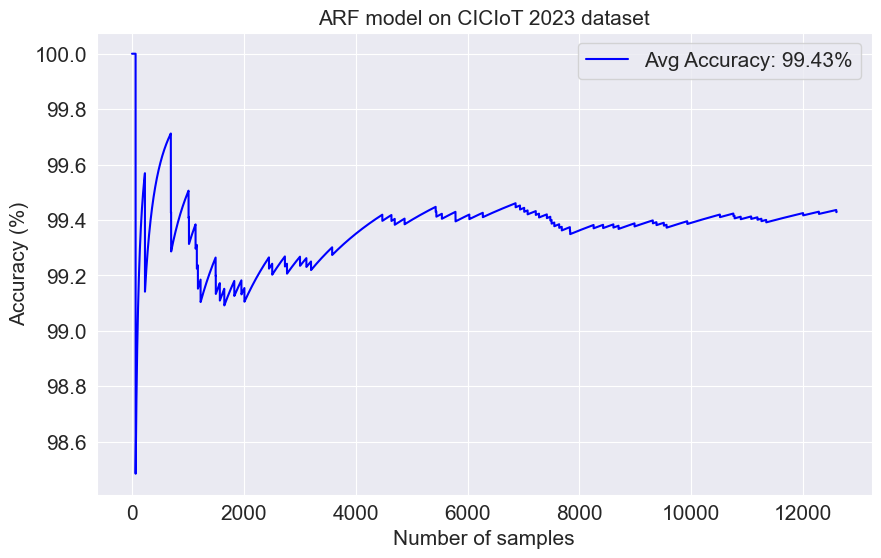

In [31]:
%%time
# Use the Adaptive Random Forest (ARF) model with ADWIN drift detector as a baseline model
name = "ARF model"
model = forest.ARFClassifier(n_models = 3,drift_detector=EDDM()) # Define the model
t, m = adaptive_learning(model, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m, name) # Draw the figure of how the real-time accuracy changes with the number of samples

Sample 0: True label: 1, Predicted label: 1
Sample 80: True label: 1, Predicted label: 1
Sample 160: True label: 0, Predicted label: 0
Sample 240: True label: 0, Predicted label: 0
Sample 320: True label: 1, Predicted label: 1
Sample 400: True label: 1, Predicted label: 1
Sample 480: True label: 1, Predicted label: 1
Sample 560: True label: 1, Predicted label: 1
Sample 640: True label: 0, Predicted label: 0
Sample 720: True label: 1, Predicted label: 1
Sample 800: True label: 0, Predicted label: 0
Sample 880: True label: 1, Predicted label: 1
Sample 960: True label: 1, Predicted label: 1
Sample 1040: True label: 1, Predicted label: 1
Sample 1120: True label: 0, Predicted label: 0
Sample 1200: True label: 0, Predicted label: 0
Sample 1280: True label: 0, Predicted label: 0
Sample 1360: True label: 0, Predicted label: 0
Sample 1440: True label: 1, Predicted label: 0
Sample 1520: True label: 0, Predicted label: 0
Sample 1600: True label: 0, Predicted label: 0
Sample 1680: True label: 0, P

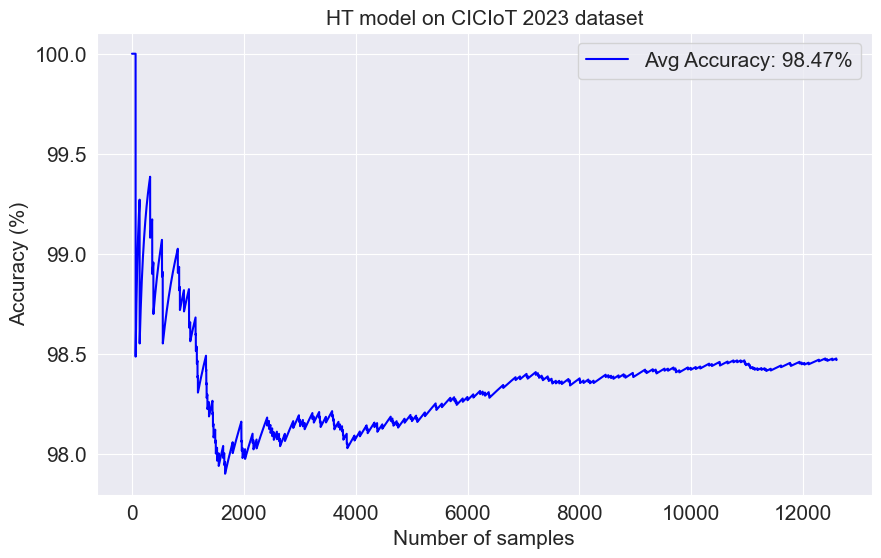

In [32]:
%%time
# Use the Hoeffding Tree (HT) model
name2 = "HT model"
model2 = tree.HoeffdingTreeClassifier()  # Define the model
t2, m2 = adaptive_learning(model2, X_train, y_train, X_test, y_test)  # Learn the model on the dataset
acc_fig(t2, m2, name2)  # Draw the figure of how the real-time accuracy changes with the number of samples


Sample 0: True label: 1, Predicted label: 1
Sample 80: True label: 1, Predicted label: 1
Sample 160: True label: 0, Predicted label: 0
Sample 240: True label: 0, Predicted label: 0
Sample 320: True label: 1, Predicted label: 1
Sample 400: True label: 1, Predicted label: 1
Sample 480: True label: 1, Predicted label: 1
Sample 560: True label: 1, Predicted label: 1
Sample 640: True label: 0, Predicted label: 0
Sample 720: True label: 1, Predicted label: 1
Sample 800: True label: 0, Predicted label: 0
Sample 880: True label: 1, Predicted label: 1
Sample 960: True label: 1, Predicted label: 1
Sample 1040: True label: 1, Predicted label: 1
Sample 1120: True label: 0, Predicted label: 0
Sample 1200: True label: 0, Predicted label: 0
Sample 1280: True label: 0, Predicted label: 0
Sample 1360: True label: 0, Predicted label: 0
Sample 1440: True label: 1, Predicted label: 1
Sample 1520: True label: 0, Predicted label: 0
Sample 1600: True label: 0, Predicted label: 0
Sample 1680: True label: 0, P

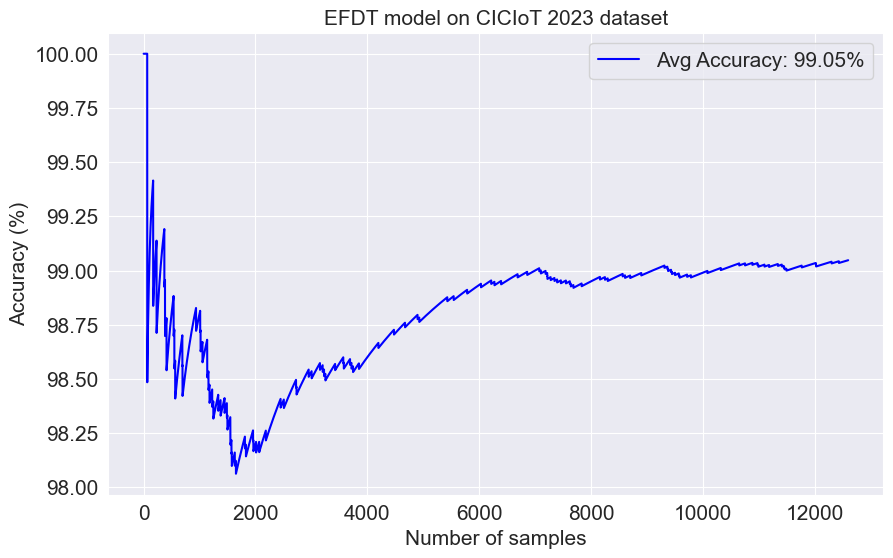

In [33]:
%%time
# Use the Extremely Fast Decision Tree (EFDT) model
name3 = "EFDT model"
model3 = tree.ExtremelyFastDecisionTreeClassifier()  # Define the model
t3, m3 = adaptive_learning(model3, X_train, y_train, X_test, y_test)  # Learn the model on the dataset
acc_fig(t3, m3, name3)  # Draw the figure of how the real-time accuracy changes with the number of samples


Sample 0: True label: 1, Predicted label: 1
Sample 80: True label: 1, Predicted label: 1
Sample 160: True label: 0, Predicted label: 0
Sample 240: True label: 0, Predicted label: 0
Sample 320: True label: 1, Predicted label: 1
Sample 400: True label: 1, Predicted label: 1
Sample 480: True label: 1, Predicted label: 1
Sample 560: True label: 1, Predicted label: 1
Sample 640: True label: 0, Predicted label: 0
Sample 720: True label: 1, Predicted label: 1
Sample 800: True label: 0, Predicted label: 0
Sample 880: True label: 1, Predicted label: 1
Sample 960: True label: 1, Predicted label: 1
Sample 1040: True label: 1, Predicted label: 1
Sample 1120: True label: 0, Predicted label: 0
Sample 1200: True label: 0, Predicted label: 0
Sample 1280: True label: 0, Predicted label: 0
Sample 1360: True label: 0, Predicted label: 0
Sample 1440: True label: 1, Predicted label: 1
Sample 1520: True label: 0, Predicted label: 0
Sample 1600: True label: 0, Predicted label: 0
Sample 1680: True label: 0, P

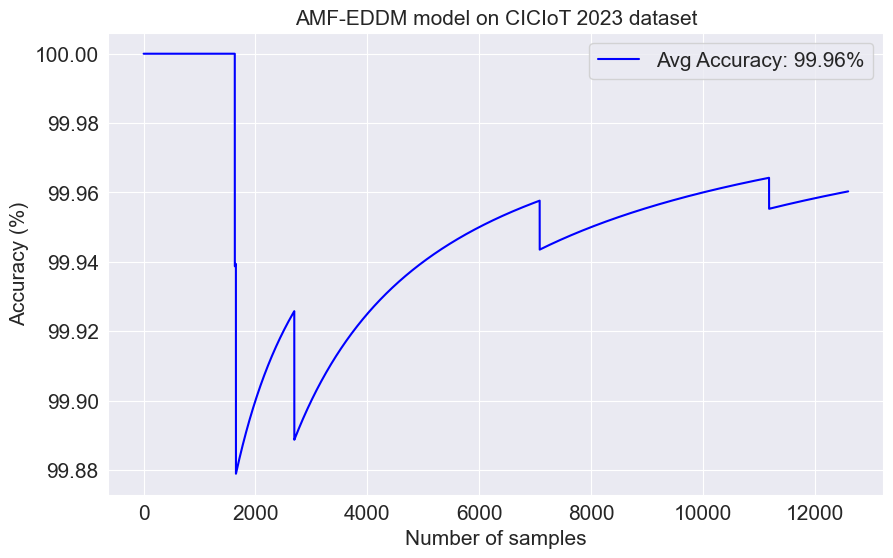

In [34]:
%%time
# Use the AMF-EDDM model
name4 = "AMF-EDDM model"
model4 = forest.AMFClassifier()  # Define the model
t4, m4 = adaptive_learning(model4, X_train, y_train, X_test, y_test)  # Learn the model on the dataset
acc_fig(t4, m4, name4)  # Draw the figure of how the real-time accuracy changes with the number of samples


Sample 0: True label: 1, Predicted label: 1
Sample 80: True label: 1, Predicted label: 1
Sample 160: True label: 0, Predicted label: 0
Sample 240: True label: 0, Predicted label: 0
Sample 320: True label: 1, Predicted label: 1
Sample 400: True label: 1, Predicted label: 1
Sample 480: True label: 1, Predicted label: 1
Sample 560: True label: 1, Predicted label: 1
Sample 640: True label: 0, Predicted label: 0
Sample 720: True label: 1, Predicted label: 1
Sample 800: True label: 0, Predicted label: 0
Sample 880: True label: 1, Predicted label: 1
Sample 960: True label: 1, Predicted label: 1
Sample 1040: True label: 1, Predicted label: 1
Sample 1120: True label: 0, Predicted label: 0
Sample 1200: True label: 0, Predicted label: 0
Sample 1280: True label: 0, Predicted label: 0
Sample 1360: True label: 0, Predicted label: 0
Sample 1440: True label: 1, Predicted label: 1
Sample 1520: True label: 0, Predicted label: 0
Sample 1600: True label: 0, Predicted label: 0
Sample 1680: True label: 0, P

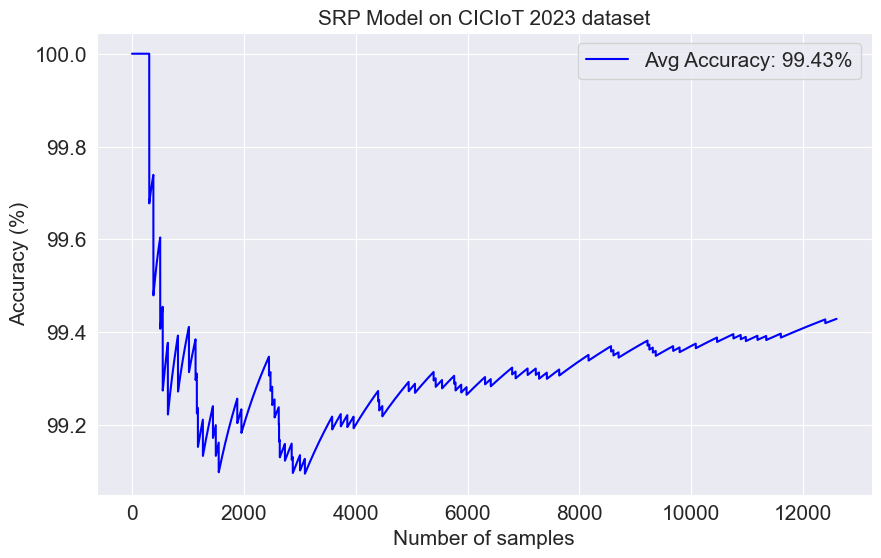

In [35]:
%%time
# Use the Hoeffding Tree (HT) model 
name5 = "SRP Model"
model5 = ensemble.SRPClassifier() # Define the model
t, m5 = adaptive_learning(model5, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m5, name5) # Draw the figure of how the real-time accuracy changes with the number of samples

In [36]:
from river import preprocessing

In [ ]:
%time
# Use the Hoeffding Tree (HT) model 
name6 = "LB model"
model6 = ensemble.LeveragingBaggingClassifier(
    
    model=(
        preprocessing.StandardScaler() |
        ensemble.SRPClassifier()
    ),
    n_models=3,
    seed=42
)

# Define the model
t, m6 = adaptive_learning(model6, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m6, name6) # Draw the figure of how the real-time accuracy changes with the number of samples

In [ ]:
%%time
# Use the Leveraging Bagging (LB) model
name6 = "LB model"
model6 = ensemble.LeveragingBaggingClassifier(
    model=(
        preprocessing.StandardScaler() |  # Preprocessing with standard scaling
        tree.ExtremelyFastDecisionTreeClassifier()  # Base model
    ),
    n_models=3,  # Number of models in the ensemble
    seed=42  # Random seed for reproducibility
)

# Set up logger for drift detection
logger6 = setup_logger("lb_model_drift_detection.log")

# Learn the model on the dataset
t6, m6, logger6 = adaptive_learning(model6, X_train, y_train, X_test, y_test, logger=logger6)

# Draw the figure of how the real-time accuracy changes with the number of samples
acc_fig(t6, m6, name6)


In [ ]:
%%time
# Use the Leveraging Bagging (LB) model
name6 = "LB model"
model6 = ensemble.LeveragingBaggingClassifier(
    model=(
        preprocessing.StandardScaler() |  # Preprocessing with standard scaling
        tree.HoeffdingAdaptiveTreeClassifier()
    ),
    n_models=3,  # Number of models in the ensemble
    seed=42  # Random seed for reproducibility
)

# Set up logger for drift detection
logger6 = setup_logger("lb_model_drift_detection.log")

# Learn the model on the dataset
t6, m6, logger6 = adaptive_learning(model6, X_train, y_train, X_test, y_test, logger=logger6)

# Draw the figure of how the real-time accuracy changes with the number of samples
acc_fig(t6, m6, name6)


In [ ]:
%%time
# Use the Leveraging Bagging (LB) model
name6 = "LB model"
model6 = ensemble.LeveragingBaggingClassifier(
    model=(
        preprocessing.StandardScaler() |  # Preprocessing with standard scaling
        tree.HoeffdingTreeClassifier()
    ),
    n_models=3,  # Number of models in the ensemble
    seed=42  # Random seed for reproducibility
)

# Set up logger for drift detection
logger6 = setup_logger("lb_model_drift_detection.log")

# Learn the model on the dataset
t6, m6, logger6 = adaptive_learning(model6, X_train, y_train, X_test, y_test, logger=logger6)

# Draw the figure of how the real-time accuracy changes with the number of samples
acc_fig(t6, m6, name6)


Sample 0: True label: 1, Predicted label: 1
Sample 80: True label: 1, Predicted label: 1
Sample 160: True label: 0, Predicted label: 0
Sample 240: True label: 0, Predicted label: 0
Sample 320: True label: 1, Predicted label: 1
Sample 400: True label: 1, Predicted label: 1
Sample 480: True label: 1, Predicted label: 1
Sample 560: True label: 1, Predicted label: 1
Sample 640: True label: 0, Predicted label: 0
Sample 720: True label: 1, Predicted label: 1
Sample 800: True label: 0, Predicted label: 0
Sample 880: True label: 1, Predicted label: 1
Sample 960: True label: 1, Predicted label: 1
Sample 1040: True label: 1, Predicted label: 1
Sample 1120: True label: 0, Predicted label: 0
Sample 1200: True label: 0, Predicted label: 0
Sample 1280: True label: 0, Predicted label: 0
Sample 1360: True label: 0, Predicted label: 0
Sample 1440: True label: 1, Predicted label: 1
Sample 1520: True label: 0, Predicted label: 0
Sample 1600: True label: 0, Predicted label: 0
Sample 1680: True label: 0, P

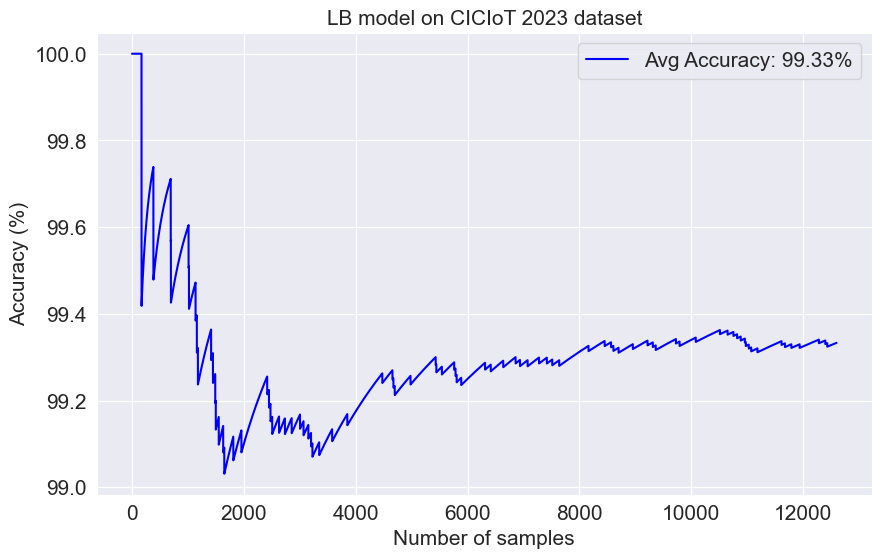

In [43]:
%%time
# Use the Leveraging Bagging (LB) model
name6 = "LB model"
model6 = ensemble.LeveragingBaggingClassifier(
    model=(
        preprocessing.StandardScaler() |  # Preprocessing with standard scaling
        forest.ARFClassifier()
    ),
    n_models=3,  # Number of models in the ensemble
    seed=42  # Random seed for reproducibility
)


# Learn the model on the dataset
t6, m6 = adaptive_learning(model6, X_train, y_train, X_test, y_test)

# Draw the figure of how the real-time accuracy changes with the number of samples

acc_fig(t6, m6, name6)

In [44]:
%%time
# Use the Leveraging Bagging (LB) model
name6_AMF = "LB model"
model6_AMF = ensemble.LeveragingBaggingClassifier(
    model=(
        preprocessing.StandardScaler() |  # Preprocessing with standard scaling
        forest.AMFClassifier()
    ),
    n_models=3,  # Number of models in the ensemble
    seed=42  # Random seed for reproducibility
)


# Learn the model on the dataset
t6_AMF, m6_AMF = adaptive_learning(model6_AMF, X_train, y_train, X_test, y_test)

# Draw the figure of how the real-time accuracy changes with the number of samples
acc_fig(t6_AMF, m6_AMF)


Sample 0: True label: 1, Predicted label: 1
Sample 80: True label: 1, Predicted label: 1
Sample 160: True label: 0, Predicted label: 0
Sample 240: True label: 0, Predicted label: 0
Sample 320: True label: 1, Predicted label: 1
Sample 400: True label: 1, Predicted label: 1
Sample 480: True label: 1, Predicted label: 1
Sample 560: True label: 1, Predicted label: 1
Sample 640: True label: 0, Predicted label: 0
Sample 720: True label: 1, Predicted label: 1
Sample 800: True label: 0, Predicted label: 0
Sample 880: True label: 1, Predicted label: 1
Sample 960: True label: 1, Predicted label: 1
Sample 1040: True label: 1, Predicted label: 1
Sample 1120: True label: 0, Predicted label: 0
Sample 1200: True label: 0, Predicted label: 0
Sample 1280: True label: 0, Predicted label: 0
Sample 1360: True label: 0, Predicted label: 0
Sample 1440: True label: 1, Predicted label: 1
Sample 1520: True label: 0, Predicted label: 0
Sample 1600: True label: 0, Predicted label: 0
Sample 1680: True label: 0, P

TypeError: acc_fig() missing 1 required positional argument: 'name'

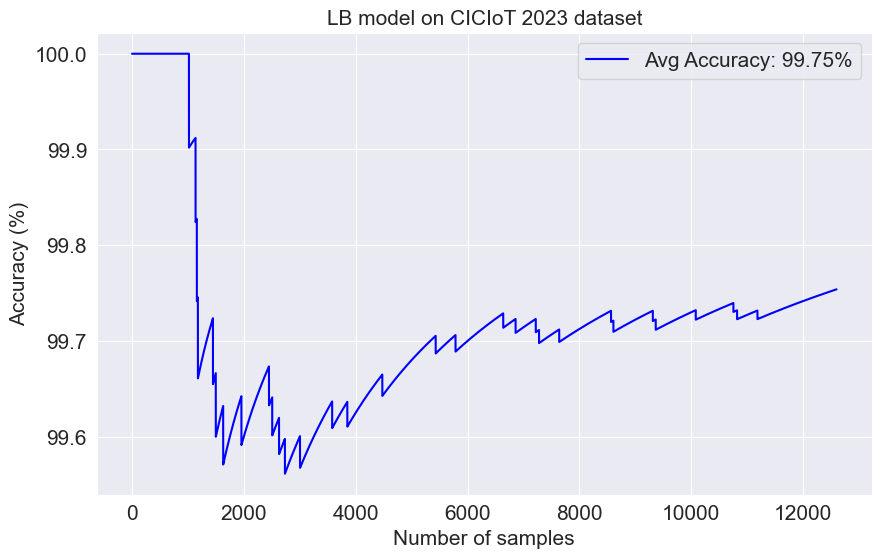

In [45]:
acc_fig(t6_AMF, m6_AMF, name6)

In [46]:
import pickle
with open('DOR_Node.pkl', 'wb') as file:
    pickle.dump(model4, file)

In [ ]:
%%time
# Use the Leveraging Bagging (LB) model
name6 = "LB model"
model6 = ensemble.LeveragingBaggingClassifier(
    model=(
        preprocessing.StandardScaler() |  # Preprocessing with standard scaling
        tree.SRPClassifier()
    ),
    n_models=3,  # Number of models in the ensemble
    seed=42  # Random seed for reproducibility
)

# Set up logger for drift detection
logger6 = setup_logger("lb_model_drift_detection.log")

# Learn the model on the dataset
t6, m6, logger6 = adaptive_learning(model6, X_train, y_train, X_test, y_test, logger=logger6)

# Draw the figure of how the real-time accuracy changes with the number of samples
acc_fig(t6, m6, name6)


In [ ]:
%%time
# Use the ADWIN Bagging (Adwinbagging) model
name7 = "Adwinbagging model"
model7 = ensemble.ADWINBaggingClassifier(
    model=(
        preprocessing.StandardScaler() |  # Preprocessing with standard scaling
        tree.HoeffdingAdaptiveTreeClassifier()  # Base model
    ),
    n_models=3,  # Number of models in the ensemble
    seed=42  # Random seed for reproducibility
)

# Set up logger for drift detection
logger7 = setup_logger("adwinbagging_model_drift_detection.log")

# Learn the model on the dataset
t7, m7, logger7 = adaptive_learning(model7, X_train, y_train, X_test, y_test, logger=logger7)

# Draw the figure of how the real-time accuracy changes with the number of samples
acc_fig(t7, m7, name7)


In [ ]:
%%time
# Use the ADWIN Bagging (Adwinbagging) model
name7 = "Adwinbagging model"
model7 = ensemble.ADWINBaggingClassifier(
    model=(
        preprocessing.StandardScaler() |  # Preprocessing with standard scaling
        tree.HoeffdingTreeClassifier()  # Base model
    ),
    n_models=3,  # Number of models in the ensemble
    seed=42  # Random seed for reproducibility
)

# Set up logger for drift detection
logger7 = setup_logger("adwinbagging_model_drift_detection.log")

# Learn the model on the dataset
t7, m7, logger7 = adaptive_learning(model7, X_train, y_train, X_test, y_test, logger=logger7)

# Draw the figure of how the real-time accuracy changes with the number of samples
acc_fig(t7, m7, name7)


In [ ]:
%%time
# Use the ADWIN Bagging (Adwinbagging) model
name7 = "Adwinbagging model"
model7 = ensemble.ADWINBaggingClassifier(
    model=(
        preprocessing.StandardScaler() |  # Preprocessing with standard scaling
        tree.ARFClassifier()  # Base model
    ),
    n_models=3,  # Number of models in the ensemble
    seed=42  # Random seed for reproducibility
)

# Set up logger for drift detection
logger7 = setup_logger("adwinbagging_model_drift_detection.log")

# Learn the model on the dataset
t7, m7, logger7 = adaptive_learning(model7, X_train, y_train, X_test, y_test, logger=logger7)

# Draw the figure of how the real-time accuracy changes with the number of samples
acc_fig(t7, m7, name7)


In [ ]:
%%time
# Use the ADWIN Bagging (Adwinbagging) model
name7 = "Adwinbagging model"
model7 = ensemble.ADWINBaggingClassifier(
    model=(
        preprocessing.StandardScaler() |  # Preprocessing with standard scaling
        tree.AMFClassifier()  # Base model
    ),
    n_models=3,  # Number of models in the ensemble
    seed=42  # Random seed for reproducibility
)

# Set up logger for drift detection
logger7 = setup_logger("adwinbagging_model_drift_detection.log")

# Learn the model on the dataset
t7, m7, logger7 = adaptive_learning(model7, X_train, y_train, X_test, y_test, logger=logger7)

# Draw the figure of how the real-time accuracy changes with the number of samples
acc_fig(t7, m7, name7)


In [ ]:
%%time
# Use the ADWIN Bagging (Adwinbagging) model
name7 = "Adwinbagging model"
model7 = ensemble.ADWINBaggingClassifier(
    model=(
        preprocessing.StandardScaler() |  # Preprocessing with standard scaling
        tree.SRPClassifier()  # Base model
    ),
    n_models=3,  # Number of models in the ensemble
    seed=42  # Random seed for reproducibility
)

# Set up logger for drift detection
logger7 = setup_logger("adwinbagging_model_drift_detection.log")

# Learn the model on the dataset
t7, m7, logger7 = adaptive_learning(model7, X_train, y_train, X_test, y_test, logger=logger7)

# Draw the figure of how the real-time accuracy changes with the number of samples
acc_fig(t7, m7, name7)


In [ ]:
%%time
# Use the ADWIN Bagging (Adwinbagging) model
name8 = "AdaBoost model"
model8 = ensemble.AdaBoostClassifier(
    model=(
        preprocessing.StandardScaler() |  # Preprocessing with standard scaling
        tree.SRPClassifier()  # Base model
    ),
    n_models=3,  # Number of models in the ensemble
    seed=42  # Random seed for reproducibility
)

# Set up logger for drift detection
logger9 = setup_logger("adwinbagging_model_drift_detection.log")

# Learn the model on the dataset
t8, m8, logger8 = adaptive_learning(model8, X_train, y_train, X_test, y_test, logger=logger8)

# Draw the figure of how the real-time accuracy changes with the number of samples
acc_fig(t8, m8, name8)
